# Counting everything in DPLA

Following on [part one](https://github.com/dchud/notebooks/blob/master/20160229-counting-things-in-dpla-with-sparksql.ipynb), let's take a look at querying everything in DPLA.  In the short term my goal is to replicate recent work by [Corey Harper](https://open.library.ubc.ca/cIRcle/collections/55474/items/1.0220818) and [Mark Phillips](http://vphill.com/journal/post/5899/) using a tool chain that goes fast.  Ideally this is something Corey and Mark and others could use to then take their analyses further faster.

## Assumptions and setup notes

I've spent some time smoothing this path a bit and am confident I have a working pattern that allows me to bring up a live environment quickly and answer ad hoc queries within minutes and sometimes only seconds, even against all of the 11 million records in the [April DPLA Bulk Download](http://dp.la/info/developers/download/?prefix=2016/04/).  There's nothing particularly innovative here, just a set of patterns that seem to work.  Your computing environment might mean you have to or want to make different choices, but this is working for me.

Key assumptions:

 * you have a fairly big machine (lots of cores and a few dozen gig of ram) or can use AWS or another cloud provider
 * if you need it, you don't mind paying a few bucks for a few hours of fiddling with rented servers
 * you have some sysadmin chops
 
All that said, here's the rough process I went through to prep the data.  All of this has been done using AWS EC2/EBS instances that cost a quarter or two per hour.

 * download the `all.json.gz` file (4.7G compressed, ~60G uncompressed)
 * split the data into many smaller files using something like `zcat all.json | split -b 64M`, generating a directory full of many files like `['xaa', 'xab', ...]`
 * convert the set-oriented json data into line-delimited json records using a pipeline like this one, in spark:
 
```python
> raw_in = sc.textFile('x*') \
    .map(lambda line: line[1:] if line.startswith(',') and len(line) > 1 else line) \
    .filter(lambda line: len(line) > 0 and not line[0] in ['[', ']'])
> json_in = sqlContext.read.json(raw_in)
```

 * write the data back out into [parquet files](parquet.apache.org):

```python
> json_in.write.save('/data/all.parquet')
> pq_in = sqlContext.read.load('/data/all.parquet')
```

These steps will take about 15-20 minutes with a fairly beefy EC2 instance.  Most of the time is spent splitting, loading in, and parsing the json, then writing it back out into the parquet file.  Once it's saved as parquet, loading it back in is super fast.

In addition to these steps within spark, I also created two EBS volumes for use with EC2 - one (~4GB) I mount as "`/tools`", containing spark, anaconda, and some environment setup scripts, and another (~10GB) I mount as "`/data`", where I save the parquet output.  With these in place I can shut down an EC2 instance when I'm done with it, then re-attach the EBS volumes a day or two later when I'm ready to get back to work without having to set up the new EC2 instance or re-process the data again.  I tried two other approaches but didn't get them right, for now at least: (1) loading data right from the public S3 bucket DPLA provides, and (2) avoiding the gunzip/split step.  I don't know what went wrong with the S3 URL-based loading, and other approaches to loading the data resulted in suboptimal file chunking.  Spark seems particular about how it partitions data depending on whether your `read.load()` call reaches for a gzipped file or not, and no combination of parameters I tried got it to work the way I wanted.  I'm still scratching my head at that.

Parquet is a good choice for a few reasons.  First, it uses the avro-style inferred schema spark generates when it loads the data from JSON; second, it writes out compact, compressed file chunks; third, its column orientation makes it ideal for the kinds of queries Corey and Mark have been running.  There has been a ton of development in this area of compact, efficient file formats the past few years, and the built-in support in spark is evidence that it's ready for us to take advantage of without barely lifting a finger.

Two quick suggestions for our friends at DPLA:

 * consider making these export files line-delimited, rather than set-oriented
 * consider making a version available using a column-oriented file format like parquet

## Getting started querying the data

With the parquet data in hand, we have two options:  SQL queries using SparkSQL, and straight up manipulation in Python using some of Spark's great functional tools.  We'll probably do a little of both.

In [2]:
d = sqlContext.read.load('/data/201604-all.parquet')

In [3]:
d.registerTempTable('dpla')

In [4]:
record_count = sqlContext.sql("SELECT COUNT(*) AS the_count FROM dpla")

In [5]:
%time record_count.show()

+---------+
|the_count|
+---------+
| 11788875|
+---------+

CPU times: user 2.98 ms, sys: 252 µs, total: 3.23 ms
Wall time: 9.91 s


Pretty fast considering we didn't have to define a schema ourselves, yeah?  Here's what's going on under the hood:

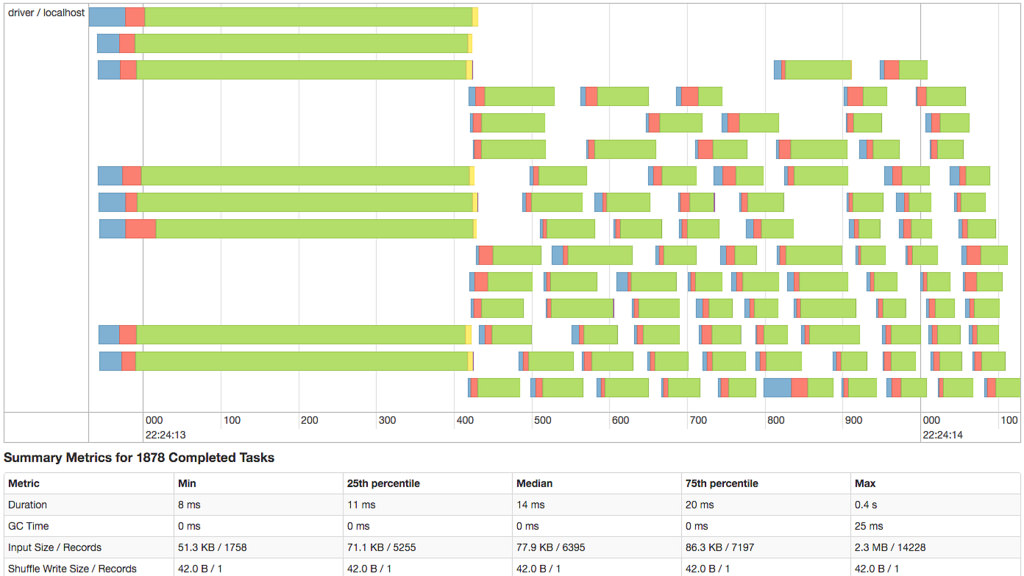

In [10]:
from IPython.display import Image
Image('https://farm2.staticflickr.com/1685/25794999084_e9a39665af_b.jpg')

That's eight virtual cpus processing the data 1,758-14,228 records at a time over 1,878 tasks most of which took less than 20ms.  I like spark. 

In Corey's work, he breaks the items down by collection, type, and the presence of several metadata attributes.  Here's a first cut at getting something like that.

In [32]:
provider_types = sqlContext.sql("""
SELECT `_source`.provider.name AS n, `_source`.sourceResource.type AS t,
    COUNT(*) AS c 
FROM dpla
GROUP BY `_source`.provider.name, `_source`.sourceResource.type
ORDER BY c DESC
""")

Note the use of backticks in the column names.  Leading underscores and at-signs in the DPLA export requires this extra step - it feels like a side effect from having XML somewhere earlier in their processing pipeline.  It would be nice to have cleaner names, but as you can see, it doesn't stop us.

In [33]:
all_types = provider_types.collect()

In [37]:
all_types[:20]

[Row(n='HathiTrust', t='text', c=2503252),
 Row(n='Smithsonian Institution', t='image', c=1213681),
 Row(n='The New York Public Library', t='image', c=899860),
 Row(n='National Archives and Records Administration', t='image', c=586530),
 Row(n='University of Southern California. Libraries', t='image', c=564381),
 Row(n='The Portal to Texas History', t='text', c=419724),
 Row(n='Mountain West Digital Library', t='text', c=410276),
 Row(n='Mountain West Digital Library', t='image', c=402347),
 Row(n='Minnesota Digital Library', t='image', c=354226),
 Row(n='University of Southern California. Libraries', t=None, c=313739),
 Row(n='California Digital Library', t='image', c=304211),
 Row(n='The New York Public Library', t='text', c=267274),
 Row(n='The Portal to Texas History', t='image', c=254636),
 Row(n='Digital Library of Georgia', t='text', c=232137),
 Row(n='University of Southern California. Libraries', t='text', c=211915),
 Row(n='Internet Archive', t='text', c=210481),
 Row(n='Digi

In [44]:
sorted(list({x['n'] or 'None' for x in all_types}))

['ARTstor',
 'Biodiversity Heritage Library',
 'California Digital Library',
 'David Rumsey',
 'Digital Commonwealth',
 'Digital Library of Georgia',
 'Empire State Digital Network',
 'Harvard Library',
 'HathiTrust',
 'Indiana Memory',
 'Internet Archive',
 'J. Paul Getty Trust',
 'Kentucky Digital Library',
 'Minnesota Digital Library',
 'Missouri Hub',
 'Mountain West Digital Library',
 'National Archives and Records Administration',
 'None',
 'North Carolina Digital Heritage Center',
 'Smithsonian Institution',
 'South Carolina Digital Library',
 'Tennessee Digital Library',
 'The New York Public Library',
 'The Portal to Texas History',
 'United States Government Publishing Office (GPO)',
 'University of Illinois at Urbana-Champaign',
 'University of Southern California. Libraries',
 'University of Virginia Library',
 'University of Washington']

In [45]:
sorted(list({x['t'] or 'None' for x in all_types}))

['None',
 '["image","text"]',
 '["image"]',
 '["physical object","image"]',
 '["physical object"]',
 '["text"]',
 'collection',
 'image',
 'moving image',
 'physical object',
 'sound',
 'text']

In Mark's work he looks at the lengths of descriptions.  Using a little `eval()` trickery (normally not a good idea) to handle the possibility of multi-valued description fields, we can nearly replicate his results: both for summary statistics of description lengths and a count of particularly short descriptions.

Some of these summary methods take about 11 minutes to complete on an 8 vCPU EC2 instance.

In [53]:
from pyspark.mllib.stat import Statistics

In [265]:
def desc_or_blank(s):
    try:
        x = s['_source']['sourceResource']['description']
        if not x:
            return ['']
        if type(x) == type([]):
            return x
        if x.startswith('[') and x.endswith(']') and "," in x:
            return eval(x)
        else:
            return ['']
    except:
        return ['']

In [282]:
descs = d.flatMap(lambda x: desc_or_blank(x))

In [267]:
descs.take(20)

['Press release announcing two exhibitions at the Dallas Museum of Fine Arts: Velox Ward, June 16–July 8, 1973, and Old Master Prints, Bequest of Calvin J. Holmes, June 16–September 3, 1973.',
 '[1] p. ; 11 in.',
 'Press release announcing the exhibition of Masters of Modern Italian Art from the Collection of Gianni Mattioli, which was exhibited at the Dallas Museum of Fine Arts January 31–March 3, 1968',
 '4 p. ; 11 in.',
 'Fact sheet from the exhibition, "Drawings by Ufert Wilke," March 8–20, 1960, held at the Dallas Museum for Contemporary Arts.',
 '[1] p. ; 11 in.',
 'Catalog from the exhibition, "Richard Tuttle," February 10–March 28, 1971, held at the Dallas Museum of Fine Arts. Includes: list of artworks in the exhibition, selected images, artist information, selected bibliography, essay.',
 '[24] p. : ill. ; 22 cm.',
 'Catalog from the exhibition, "Photographs by Clyde Dilley," January 28–March 8, 1970, held at the Dallas Museum of Fine Arts. Includes: introduction, list of art

In [268]:
desc_lengths = descs.map(lambda x: [np.array(len(x))])

In [269]:
desc_lengths.take(5)

[[array(188)], [array(15)], [array(191)], [array(13)], [array(125)]]

In [270]:
summary = Statistics.colStats(desc_lengths)

In [274]:
import math

In [276]:
print(summary.mean(), math.sqrt(summary.variance()))

[ 55.43879444] 311.33490441261006


In [277]:
print(summary.min(), summary.max())

[ 0.] [ 126427.]


In [273]:
print(summary.count())

18246749


In [283]:
short_descs = descs.map(lambda x: len(x)) \
    .filter(lambda x: x >= 1 and x <= 10) \
    .map(lambda x: (x, 1)) \
    .reduceByKey(lambda x, y: x + y)
short_descs_counts = short_descs.collect()

In [285]:
short_descs_counts

[(1, 770996),
 (2, 134149),
 (3, 24763),
 (4, 55559),
 (5, 65161),
 (6, 83831),
 (7, 56995),
 (8, 47287),
 (9, 88875),
 (10, 424467)]

## Summary

I'm tight on time due to pending travel and other work so this still feels like it's just scratching the surface.  But now there's a workflow for getting the full dataset loaded, an AWS pattern for storing and accessing results in a compact format amenable to processing with spark, and a few very basic examples that successfully reach into the simpler parts of the work Corey and Mark have been doing.

In a final notebook I'll take a more complete approach, going a level deeper into some of Corey's text mining work analyzing topics, and try to replicate some of Mark's categorizations by provider and some of the clear tables and charts that accompany his posts.